# ** Code to download and plot reservoir storage-level data from Karnataka ** 
## ** Importing libraries **

In [2]:
import mechanicalsoup
import pandas as pd
import matplotlib.pyplot as plt
import glob

** Function to save data into a csv file **

In [6]:
def save_pdDf_toCSV(pdDF, CSVfilename):
    '''
    A function to save a pandas dataframe to a csv file, usually to be 
    used in a for loop. At the end of each cycle of the loop, a dataframe
    is appended to a filename CSVfilename.
    '''
    try:
        open(CSVfilename)
    except FileNotFoundError:
        open(CSVfilename, 'w')
        f = open(CSVfilename, 'w')
        pdDF.to_csv(f, header=pdDF.columns)
    
    with open(CSVfilename, 'a') as f:
        pdDF.to_csv(f, header=False)

In the following code, we are going to try and extract information about
reservoir levels in the state of Karnataka, India. The website uses a form, the input for which are the  reservor name, the year, and the week of the year. We will use ** mechanicalsoup ** to extract this information. 

The following code works - when the website allows it to:

!!!!!!!!! ** Code ** !!!!!!!!!
```Python

url = 'https://www.ksndmc.org/Reservoir_Details.aspx'
#yearval = 2011
yearrange = range(2014,2020,1)
weekrange = range(1,53, 1)
reservoirName = 'K.R.S'

b = mechanicalsoup.StatefulBrowser()
b.open(url)


#bhadra_df = pd.DataFrame()

for yearval in yearrange:
    for weekval in weekrange:
        b.select_form('form')
        #'ctl00_cpMainContent_DropDownList1'
        #'ctl00$cpMainContent$DropDownList1'
        b["ctl00$cpMainContent$DropDownList1"] = reservoirName
        b["ctl00$cpMainContent$Year_list"] = yearval
        b["ctl00$cpMainContent$weekList"] = weekval
        b["ctl00$cpMainContent$Button1"] = "Get Details"

        r = b.submit_selected()

        result_html = r.text

        html_mechano_df = pd.read_html(result_html)[-1]
        
        colstosave = ['Reservoir', 'Flow Date', 'Present Storage(TMC)',
                      'Reservoir Level(TMC)', 'Inflow', 'Outflow']
    
        #bhadra_df = bhadra_df.append(html_mechano_df[colstosave])
        
        #html_mechano_df[colstosave].to_csv('bhadra_reservoir_add.csv',
        #                                   mode='a', header=False)
        save_pdDf_toCSV(html_mechano_df[colstosave], 
                       reservoirName+'_reservoir_add.csv')

```
!!!!!! ** End of Code ** !!!!!!

In the data, there is a problem with the way the data are available in the Karnataka website. The reservoir level is in feet but given as TMC, which is the unit for storage. I have retained this error of notation in my code.

** Important not to put b.open(url) in a loop. That works too but 
increases the time for execution as well as the chances of connection
errors **.

In [27]:
url = 'https://www.ksndmc.org/Reservoir_Details.aspx'
#yearval = 2011
yearrange = range(2014,2020,1)
weekrange = range(1,53, 1)
reservoirName = 'Tungabhadra'

b = mechanicalsoup.StatefulBrowser()
b.open(url)


#bhadra_df = pd.DataFrame()

for yearval in yearrange:
    for weekval in weekrange:
        b.select_form('form')
        #'ctl00_cpMainContent_DropDownList1'
        #'ctl00$cpMainContent$DropDownList1'
        b["ctl00$cpMainContent$DropDownList1"] = reservoirName
        b["ctl00$cpMainContent$Year_list"] = yearval
        b["ctl00$cpMainContent$weekList"] = weekval
        b["ctl00$cpMainContent$Button1"] = "Get Details"

        r = b.submit_selected()

        result_html = r.text

        html_mechano_df = pd.read_html(result_html)[-1]
        
        colstosave = ['Reservoir', 'Flow Date', 'Present Storage(TMC)',
                      'Reservoir Level(TMC)', 'Inflow', 'Outflow']
    
        #bhadra_df = bhadra_df.append(html_mechano_df[colstosave])
        
        #html_mechano_df[colstosave].to_csv('bhadra_reservoir_add.csv',
        #                                   mode='a', header=False)
        save_pdDf_toCSV(html_mechano_df[colstosave], 
                       reservoirName+'_reservoir_add.csv')

## ** Functions for plotting data **

In [8]:
def plottingKarnatakaWaterData(filename, xloc, yloc, axobj):
    '''
    function to plot daily gage level and storage, labeled by year.
    
    filename: string, path pointing to file containing data
    xloc: string, column name for x-axis. 'Full  Capacity (mcft)' is 
            what is to be used most often, especially given the code in 
            the previous cell.
    yloc: string, column name for y-axis. 'Full  Tank Level (ft.)' is 
            what is to be used most often, especially given the code in 
            the previous cell.
    axobj: axes object on which the data will be plotted
    '''
    
    df_full = pd.read_csv(filename)
    
    #df_full = df_full.fillna('-')
    grpbyyr = df_full.groupby(df_full['Flow Date'].str.split('-', expand=True)[2])
    
    for group in grpbyyr.groups:
        year = group
        df = grpbyyr.get_group(group).dropna()
        
        axobj.plot(df[xloc].astype(float), 
                   df[yloc].astype(float), 'o', label=str(year))
        
        plt.setp(axobj.get_xticklabels(), fontsize=16)
        plt.setp(axobj.get_yticklabels(), fontsize=16)
        
        axobj.set_xlabel(xloc, fontsize=16)
        axobj.set_ylabel(yloc, fontsize=16)
        
    axobj.legend(loc='lower right')
    axobj.set_title(filename.split('.')[0], fontsize=18)

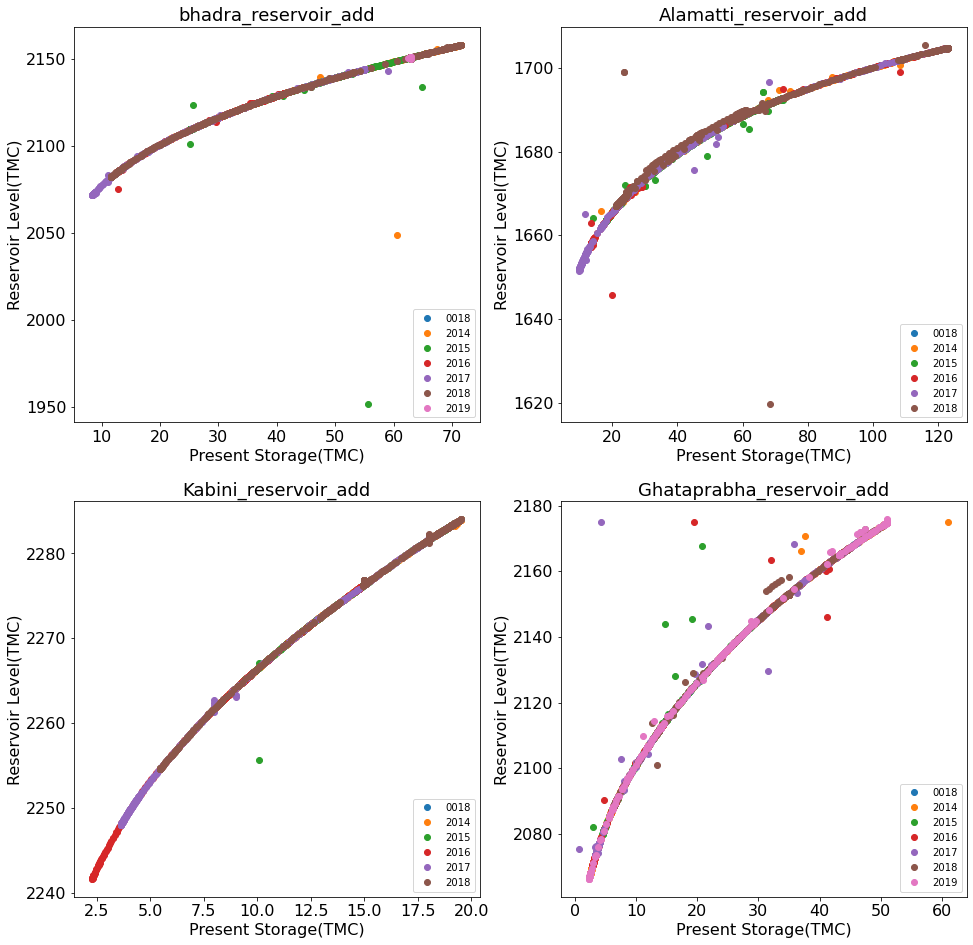

In [10]:
import matplotlib.pyplot as plt 

g, ((axa, axb), (axc, axd)) = plt.subplots(2,2, figsize=(16,16))

yloc = 'Reservoir Level(TMC)'
xloc = 'Present Storage(TMC)'

plottingKarnatakaWaterData('bhadra_reservoir_add.csv', xloc, yloc, axa)
plottingKarnatakaWaterData('Alamatti_reservoir_add.csv', xloc, yloc, axb)
plottingKarnatakaWaterData('Kabini_reservoir_add.csv', xloc, yloc, axc)
plottingKarnatakaWaterData('Ghataprabha_reservoir_add.csv', xloc, yloc, axd)

## ** Obtaining area of reservoir **

### ** Using LinearRegression and PolynomialFeatures from sklearn **

LinearRegression (from sklearn.linear_model) is what is used for fitting the data. The function is supplied by PolynomialFeatures. You can set the degree. For the case of fitting level to volume (actually, log of volume)

In [28]:
df_full = pd.read_csv('Supa_reservoir_add.csv')
yloc = 'Reservoir Level(TMC)' #in TMC
xloc = 'Present Storage(TMC)' #actually in feet

df = df_full[[xloc, yloc]]

from scipy import stats
import numpy as np

df = df[((stats.zscore(df) < 1.8)).all(axis=1)]
df = df[((stats.zscore(df) > -0.8)).all(axis=1)]

X = np.log(df.iloc[:,0:1].values)
y = df.iloc[:,1].values

# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
  
poly = PolynomialFeatures(degree = 6) 
X_poly = poly.fit_transform(X) 

poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 

# Visualising the Polynomial Regression results 
from numpy.polynomial.polynomial import polyval
deriv = np.array(lin2.coef_*np.arange(len(lin2.coef_)))[1:]

x_toplot = np.sort(np.log(df.iloc[:,0]))
areainv = polyval(x_toplot, deriv)
area_pred = np.exp(x_toplot)*areainv**(-1.)*0.3048**2*1000

X_toplot = x_toplot[:, np.newaxis]

plt.scatter(np.exp(X), y, color = 'blue') 

plt.plot(np.exp(X_toplot), lin2.predict(poly.fit_transform(X_toplot)), 
         color = 'red', lw=2) 
plt.title('Ghataprabha') 
plt.xlabel('Storage (TMC)') 
plt.ylabel('Level (ft)') 

ax = plt.gca()
axtwinx = ax.twinx()

axtwinx.plot(np.exp(x_toplot), area_pred, label='area', c='g', lw=2)

axtwinx.set_ylim([0, 100])
#axtwinx.plot(np.exp(x_toplot), area_pred_6, label='area 6', c='b', lw=2)
axtwinx.set_ylabel('Area (sq. km)')

  
plt.show()

/home/arvindn/anaconda3/envs/ee/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/home/arvindn/anaconda3/envs/ee/lib/python3.7/site-packages/scipy/stats/stats.py:2497: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
/home/arvindn/anaconda3/envs/ee/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/arvindn/anaconda3/envs/ee/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/arvindn/anaconda3/envs/ee/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/arvindn/anaconda3/envs/ee/lib/python3.7/site-packages/numpy/core/_method

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.